###Preprocessing

In [ ]:

import random
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle as pkl
import pandas as pd
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import pydot as pyd
from keras.utils.vis_utils import plot_model, model_to_dot
keras.utils.vis_utils.pydot = pyd

import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive/', force_remount=True)
#os.chdir("/content/drive/My Drive/Colab Notebooks/Stumpy")
#os.listdir()

#Downlaod the source data file from google drive
#https://drive.google.com/file/d/1WlHOzn_XEUSAnhPkv5Fb11mgHfVDiO0M/view?usp=sharing
!gdown --id 1WlHOzn_XEUSAnhPkv5Fb11mgHfVDiO0M

unpickled_df = pd.read_pickle("./global_dataframe.pkl")
unpickled_df=unpickled_df.astype(float) 

unpickled_df.head()

Mounted at /content/drive/


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1233,1234,1235,1236,1237,1238,1239,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272
patient0,13.0,6.0,22.0,6.0,12.0,22.0,12.0,12.0,16.0,12.0,22.0,19.0,19.0,17.0,3.0,22.0,14.0,12.0,20.0,20.0,18.0,20.0,17.0,12.0,16.0,16.0,1.0,25.0,20.0,14.0,19.0,6.0,20.0,18.0,7.0,22.0,25.0,25.0,16.0,4.0,...,12.0,3.0,3.0,13.0,20.0,19.0,3.0,3.0,19.0,3.0,12.0,11.0,7.0,3.0,3.0,19.0,3.0,7.0,19.0,3.0,3.0,11.0,6.0,4.0,5.0,4.0,4.0,19.0,5.0,16.0,22.0,12.0,11.0,7.0,22.0,11.0,12.0,8.0,25.0,20.0
patient1,13.0,6.0,22.0,6.0,12.0,22.0,12.0,12.0,16.0,12.0,22.0,19.0,19.0,17.0,3.0,22.0,14.0,12.0,20.0,20.0,18.0,20.0,17.0,12.0,16.0,16.0,1.0,25.0,20.0,14.0,19.0,6.0,20.0,18.0,7.0,22.0,25.0,25.0,16.0,4.0,...,12.0,3.0,3.0,13.0,20.0,19.0,3.0,3.0,19.0,3.0,12.0,11.0,7.0,3.0,3.0,19.0,3.0,7.0,19.0,3.0,3.0,11.0,6.0,4.0,5.0,4.0,4.0,19.0,5.0,16.0,22.0,12.0,11.0,7.0,22.0,11.0,12.0,8.0,25.0,20.0
patient2,13.0,6.0,22.0,6.0,12.0,22.0,12.0,12.0,16.0,12.0,22.0,19.0,19.0,17.0,3.0,22.0,14.0,12.0,20.0,20.0,18.0,20.0,17.0,12.0,16.0,16.0,1.0,25.0,20.0,14.0,19.0,6.0,20.0,18.0,7.0,22.0,25.0,25.0,16.0,4.0,...,12.0,3.0,3.0,13.0,20.0,19.0,3.0,3.0,19.0,3.0,12.0,11.0,7.0,3.0,3.0,19.0,3.0,7.0,19.0,3.0,3.0,11.0,6.0,4.0,5.0,4.0,4.0,19.0,5.0,16.0,22.0,12.0,11.0,7.0,22.0,11.0,12.0,8.0,25.0,20.0
patient3,13.0,6.0,22.0,6.0,12.0,22.0,12.0,12.0,16.0,12.0,22.0,19.0,19.0,17.0,3.0,22.0,14.0,12.0,20.0,20.0,18.0,20.0,17.0,12.0,16.0,16.0,1.0,25.0,20.0,14.0,19.0,6.0,20.0,18.0,7.0,22.0,25.0,25.0,16.0,4.0,...,12.0,3.0,3.0,13.0,20.0,19.0,3.0,3.0,19.0,3.0,12.0,11.0,7.0,3.0,3.0,19.0,3.0,7.0,19.0,3.0,3.0,11.0,6.0,4.0,5.0,4.0,4.0,19.0,5.0,16.0,22.0,12.0,11.0,7.0,22.0,11.0,12.0,8.0,25.0,20.0
patient4,13.0,6.0,22.0,6.0,12.0,22.0,12.0,12.0,16.0,12.0,22.0,19.0,19.0,17.0,3.0,22.0,14.0,12.0,20.0,20.0,18.0,20.0,17.0,12.0,16.0,16.0,1.0,25.0,20.0,14.0,19.0,6.0,20.0,18.0,7.0,22.0,25.0,25.0,16.0,4.0,...,12.0,3.0,3.0,13.0,20.0,19.0,3.0,3.0,19.0,3.0,12.0,11.0,7.0,3.0,3.0,19.0,3.0,7.0,19.0,3.0,3.0,11.0,6.0,4.0,5.0,4.0,4.0,19.0,5.0,16.0,22.0,12.0,11.0,7.0,22.0,11.0,12.0,8.0,25.0,20.0


Find the top 80s highest standart deviation index

In [ ]:
K = 10 # We want the indices of the 80 largest values

std=np.std(unpickled_df,axis=0)
std_np = np.array(std)

idx=np.argpartition(std_np,-K)[-K:]
print(std_np[idx])
print(idx)

[1.80026659 1.94140557 1.92097026 2.25050518 2.44463727 2.29199936
 2.29529759 2.42549322 2.7814086  2.42803959]
[514 260 515 263 261 476 262 521 259 519]


Set the 80s index to the filter list, so that we only focus on the top 80s features

In [ ]:
idx=np.sort(idx)
filter_list=idx.tolist()


filtered_unpickled_df=unpickled_df.filter(filter_list)

filtered_unpickled_df.head()

,259,260,261,262,263,476,514,515,519,521
patient0,1.0,7.0,1.0,1.0,1.0,19.0,6.0,5.0,1.0,1.0
patient1,1.0,7.0,1.0,1.0,1.0,19.0,6.0,5.0,1.0,1.0
patient2,1.0,7.0,1.0,1.0,1.0,19.0,6.0,5.0,1.0,1.0
patient3,1.0,7.0,1.0,1.0,1.0,19.0,6.0,5.0,1.0,1.0
patient4,1.0,7.0,1.0,1.0,1.0,19.0,6.0,5.0,1.0,1.0


In [ ]:
Amino_2d_np=np.array(filtered_unpickled_df)
print(Amino_2d_np)
print(Amino_2d_np.shape)
print(np.transpose(Amino_2d_np))
Amino_2d_np_transpose=np.transpose(Amino_2d_np)
print(Amino_2d_np_transpose.shape)

[[1. 7. 1. ... 5. 1. 1.]
 [1. 7. 1. ... 5. 1. 1.]
 [1. 7. 1. ... 5. 1. 1.]
 ...
 [1. 7. 1. ... 5. 1. 1.]
 [1. 7. 1. ... 5. 1. 1.]
 [1. 7. 1. ... 5. 1. 1.]]
(22365, 10)
[[1. 1. 1. ... 1. 1. 1.]
 [7. 7. 7. ... 7. 7. 7.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [5. 5. 5. ... 5. 5. 5.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
(10, 22365)


In [ ]:

train_ratio = 0.8
train_len = int(train_ratio * Amino_2d_np_transpose.shape[1])
print(train_len)

17892


In [ ]:
x_index = np.array(range(len(Amino_2d_np_transpose[0])))
print(x_index)

[    0     1     2 ... 22362 22363 22364]


In [ ]:
x1_trend_param = np.polyfit(x_index[:train_len], Amino_2d_np_transpose[0,:train_len], 2)
x2_trend_param = np.polyfit(x_index[:train_len], Amino_2d_np_transpose[1,:train_len], 1)
curve_function=(np.poly1d(x1_trend_param))
print(x1_trend_param)
print(x2_trend_param)

[ 1.19817779e-09 -2.66382228e-06  1.28291763e+00]
[9.77778998e-06 7.16460074e+00]


In [ ]:
x1_trend = (x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2]
x2_trend = x_index*x2_trend_param[0]+x2_trend_param[1]
x1_trend_alter= curve_function(x_index)



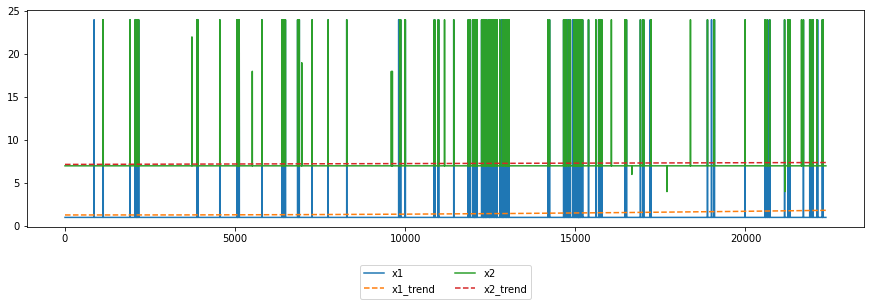

In [ ]:

plt.figure(figsize=(15, 4))
plt.plot(range(len(Amino_2d_np_transpose[0])), Amino_2d_np_transpose[0], label='x1')
plt.plot(range(len(x1_trend)), x1_trend, linestyle='--', label='x1_trend')
plt.plot(range(len(Amino_2d_np_transpose[1])), Amino_2d_np_transpose[1], label='x2')
plt.plot(range(len(x2_trend)), x2_trend, linestyle='--', label='x2_trend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [ ]:
stacked_input=np.column_stack([Amino_2d_np_transpose[i] for i in range(len(Amino_2d_np_transpose))])
print(stacked_input.shape)
print(stacked_input)

(22365, 10)
[[1. 7. 1. ... 5. 1. 1.]
 [1. 7. 1. ... 5. 1. 1.]
 [1. 7. 1. ... 5. 1. 1.]
 ...
 [1. 7. 1. ... 5. 1. 1.]
 [1. 7. 1. ... 5. 1. 1.]
 [1. 7. 1. ... 5. 1. 1.]]


In [ ]:
x_lbl = np.column_stack([stacked_input, x_index, [1]*train_len+[0]*(len(x_index)-train_len)])
print(x_lbl.shape)
print(x_lbl)

(22365, 12)
[[1.0000e+00 7.0000e+00 1.0000e+00 ... 1.0000e+00 0.0000e+00 1.0000e+00]
 [1.0000e+00 7.0000e+00 1.0000e+00 ... 1.0000e+00 1.0000e+00 1.0000e+00]
 [1.0000e+00 7.0000e+00 1.0000e+00 ... 1.0000e+00 2.0000e+00 1.0000e+00]
 ...
 [1.0000e+00 7.0000e+00 1.0000e+00 ... 1.0000e+00 2.2362e+04 0.0000e+00]
 [1.0000e+00 7.0000e+00 1.0000e+00 ... 1.0000e+00 2.2363e+04 0.0000e+00]
 [1.0000e+00 7.0000e+00 1.0000e+00 ... 1.0000e+00 2.2364e+04 0.0000e+00]]


In [ ]:
x_train_max = x_lbl[x_lbl[:, 11]==1, :10].max(axis=0)
x_train_max = x_train_max.tolist()+[1]*2  # only normalize for the first 2 columns
print(x_train_max)


[24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 1, 1]


In [ ]:
x_normalize = np.divide(x_lbl, x_train_max)
print(x_normalize.shape)
print(x_normalize)

(22365, 12)
[[4.16666667e-02 2.91666667e-01 4.16666667e-02 ... 4.16666667e-02
  0.00000000e+00 1.00000000e+00]
 [4.16666667e-02 2.91666667e-01 4.16666667e-02 ... 4.16666667e-02
  1.00000000e+00 1.00000000e+00]
 [4.16666667e-02 2.91666667e-01 4.16666667e-02 ... 4.16666667e-02
  2.00000000e+00 1.00000000e+00]
 ...
 [4.16666667e-02 2.91666667e-01 4.16666667e-02 ... 4.16666667e-02
  2.23620000e+04 0.00000000e+00]
 [4.16666667e-02 2.91666667e-01 4.16666667e-02 ... 4.16666667e-02
  2.23630000e+04 0.00000000e+00]
 [4.16666667e-02 2.91666667e-01 4.16666667e-02 ... 4.16666667e-02
  2.23640000e+04 0.00000000e+00]]


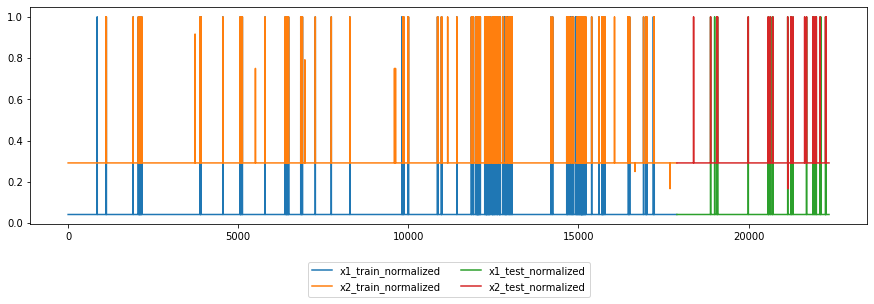

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(range(train_len), x_normalize[:train_len, 0], label='x1_train_normalized')
plt.plot(range(train_len), x_normalize[:train_len, 1], label='x2_train_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 0], label='x1_test_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 1], label='x2_test_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [ ]:
def truncate(x, feature_cols=range(11), target_cols=range(11), label_col=11, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)
X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(11), target_cols=range(11), 
                            label_col=11, train_len=200, test_len=20)
print(X_in.shape, X_out.shape, lbl.shape)

(22146, 200, 11) (22146, 20, 11) (22146,)


In [ ]:
X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)




(17692, 200, 11) (17692, 20, 11)
(4454, 200, 11) (4454, 20, 11)


In [ ]:
n_hidden = 100

input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))
print(input_train)
print(output_train)

Tensor("input_1:0", shape=(None, 200, 10), dtype=float32)
Tensor("input_2:0", shape=(None, 20, 10), dtype=float32)


### Encoder_layers

In [ ]:
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_state=True, return_sequences=True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

Tensor("lstm/transpose_1:0", shape=(None, 200, 100), dtype=float32)
Tensor("lstm/while:4", shape=(None, 100), dtype=float32)
Tensor("lstm/while:5", shape=(None, 100), dtype=float32)


In [ ]:
encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

### Decoder_layers

In [ ]:
decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
print(decoder_input)

Tensor("repeat_vector/Tile:0", shape=(None, 20, 100), dtype=float32)


In [ ]:
decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
 return_state=False, return_sequences=True)(
 decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)

Tensor("lstm_1/transpose_1:0", shape=(None, 20, 100), dtype=float32)


###Attention_layers

In [ ]:
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
print(attention)

Tensor("activation/truediv:0", shape=(None, 20, 200), dtype=float32)


In [ ]:
context = dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context)
print(context)

Tensor("batch_normalization_2/batchnorm/add_1:0", shape=(None, 20, 100), dtype=float32)


In [ ]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

Tensor("concatenate/concat:0", shape=(None, 20, 200), dtype=float32)


In [ ]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
print(out)

Tensor("time_distributed/Reshape_1:0", shape=(None, 20, 10), dtype=float32)


###Model.summary

In [ ]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 10)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 200, 100), ( 44400       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100)          400         lstm[0][1]                       
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 20, 100)      0           batch_normalization[0][0]        
_______________________________________________________________________________________

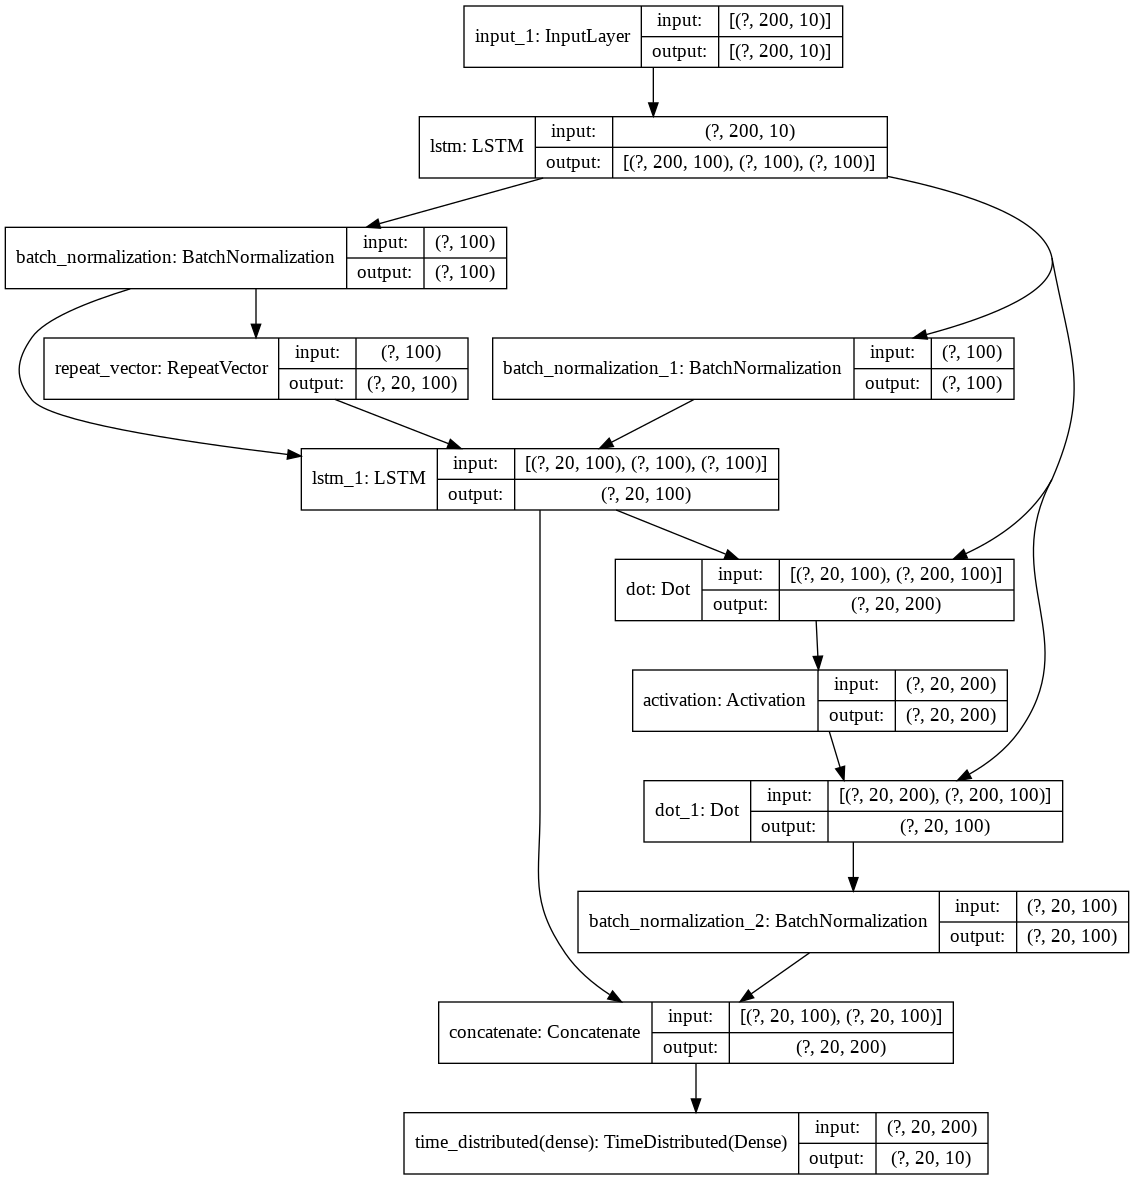

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :10], X_output_train[:, :, :10], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
model.save('model_forecasting_seq2seq.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/100
142/142 [==============================] - 170s 1s/step - loss: 0.0889 - mae: 0.0868 - val_loss: 0.0101 - val_mae: 0.0295
Epoch 2/100
142/142 [==============================] - 173s 1s/step - loss: 0.0069 - mae: 0.0290 - val_loss: 0.0100 - val_mae: 0.0341
Epoch 3/100
142/142 [==============================] - 172s 1s/step - loss: 0.0067 - mae: 0.0262 - val_loss: 0.0100 - val_mae: 0.0311
Epoch 4/100
142/142 [==============================] - 171s 1s/step - loss: 0.0066 - mae: 0.0244 - val_loss: 0.0106 - val_mae: 0.0337
Epoch 5/100
142/142 [==============================] - 171s 1s/step - loss: 0.0065 - mae: 0.0236 - val_loss: 0.0097 - val_mae: 0.0320
Epoch 6/100
142/142 [==============================] - 168s 1s/step - loss: 0.0064 - mae: 0.0230 - val_loss: 0.0101 - val_mae: 0.0301
Epoch 7/100
142/142 [==============================] - 167s 1s/step - loss: 0.0064 - mae: 0.0220 - val_loss: 0.0106 - val_mae: 0.0342
Epoch 8/100
142/142 [==============================] - 169s 1s

In [ ]:
model.save('model_forecasting_seq2seq.h5')

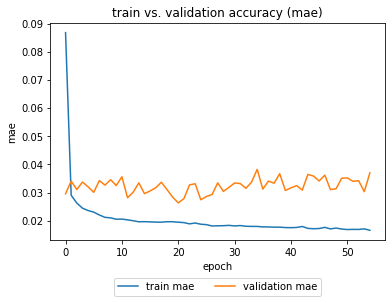

In [ ]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [ ]:
train_pred_detrend = model.predict(X_input_train[:, :, :10])*x_train_max[:10]
test_pred_detrend = model.predict(X_input_test[:, :, :10])*x_train_max[:10]
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = X_output_train[:, :, :10]*x_train_max[:10]
test_true_detrend = X_output_test[:, :, :10]*x_train_max[:10]
print(train_true_detrend.shape, test_true_detrend.shape)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


(17692, 20, 10) (4454, 20, 10)
(17692, 20, 10) (4454, 20, 10)


In [ ]:
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(17692, 20, 11) (4454, 20, 11)
(17692, 20, 11) (4454, 20, 11)


In [ ]:
data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 10]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 10]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))

train_pred: (17692, 20, 2)
train_true: (17692, 20, 2)
test_pred: (4454, 20, 2)
test_true: (4454, 20, 2)


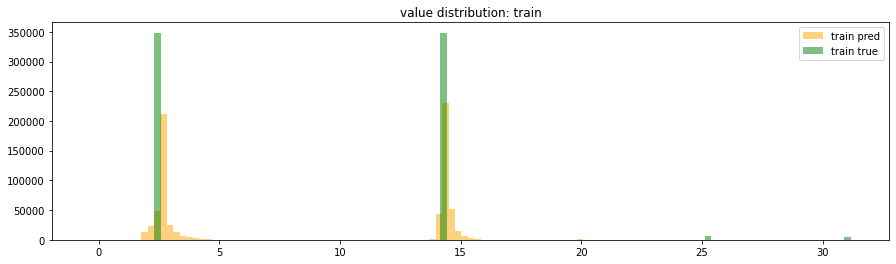

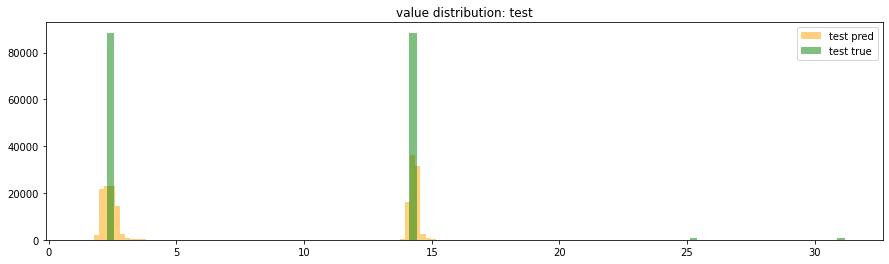

In [ ]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

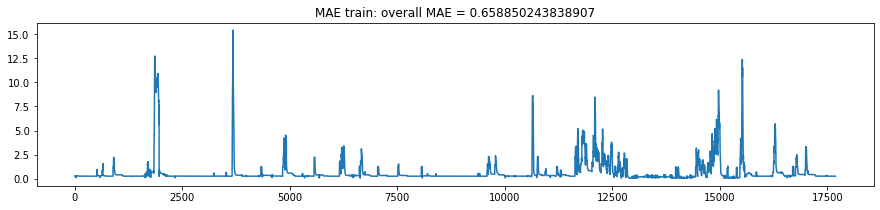

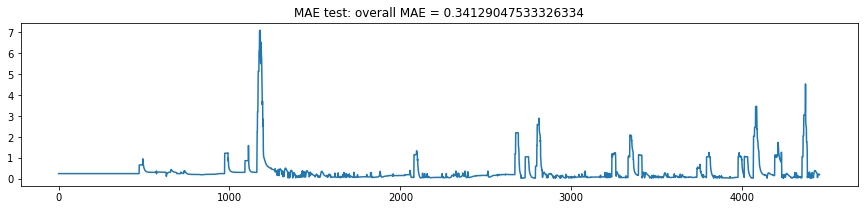

In [ ]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

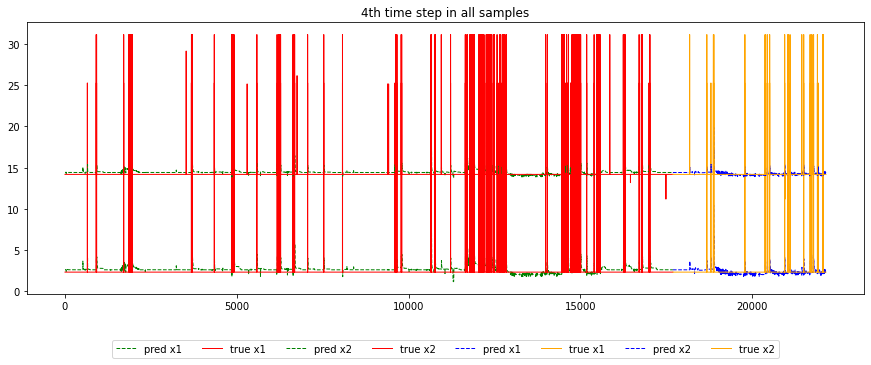

In [ ]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

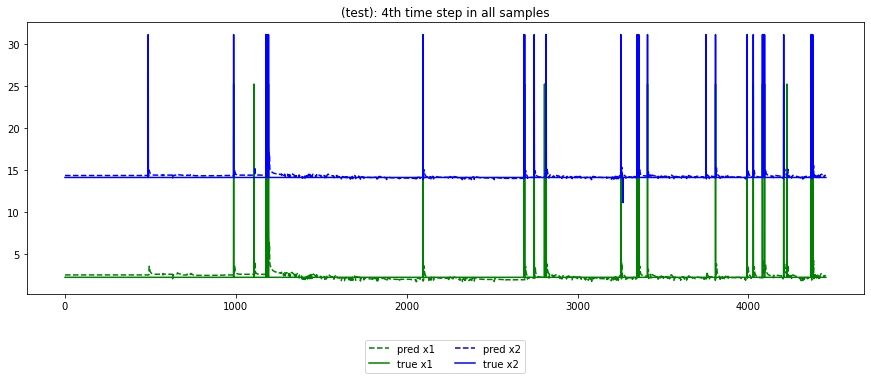

In [ ]:
lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

###Testing

In [ ]:
array1=[[1,2,3,4,5,6],[5,5,6,7,8,5]]

array2=[4,5,6,7,8,9]

print(array1[0])
arr3=np.column_stack([array1[i] for i in range(len(array1))])

print(arr3)
array4=[1,2,3,4,5,6]

arr4=np.column_stack([arr3,array4,array2])
print(arr4)

